In [32]:
import sys
import os
# Add the parent directory to the system path
sys.path.append(os.path.abspath('../'))

import mesa
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

from model import Schelling

## Testing to find wealth distribution for USA:

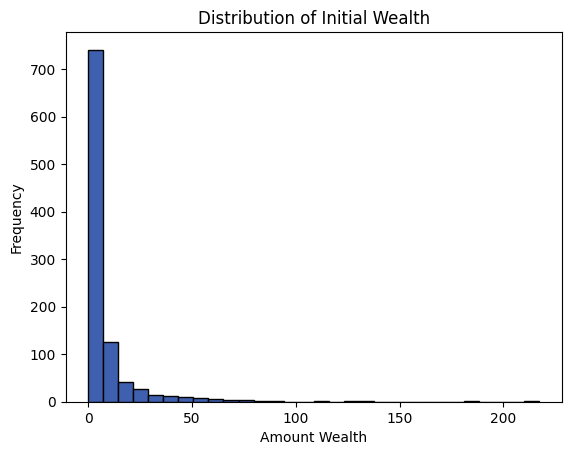

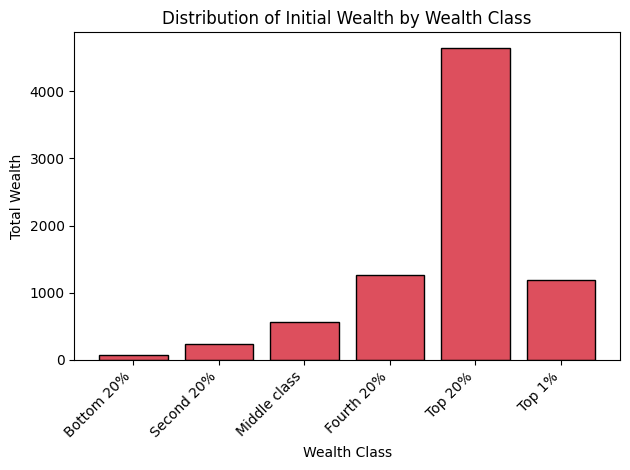

In [37]:
def plot_lognormal_dist(num_agents, mean, std_dev):
    """
    Test the distribution of initial wealth of agents
    We choose a lognormal distribution for the initial wealth of agents
    as it is a good approximation of the distribution of wealth in the USA
    """

    initial_wealth = []
    for i in range(num_agents):
        initial_wealth.append(np.random.lognormal(mean, std_dev))

    # Plotting the distribution
    plt.hist(initial_wealth, bins=30, color='#3f60af', edgecolor='black')
    plt.xlabel('Amount Wealth')
    plt.ylabel('Frequency')
    plt.title('Distribution of Initial Wealth')
    plt.show()

    return initial_wealth

def test_USAwealthDist(initial_wealth):
    """
    Tests the distribution of initial wealth of agents and plots the total wealth
    owned by each wealth class.
    
    Args:
        num_agents: Number of agents in the model
        mean: Mean of the logarithm of the distribution
        std_dev: Standard deviation of the logarithm of the distribution
    """

    # Calculate wealth thresholds for different wealth classes
    thresholds = np.percentile(initial_wealth, [99, 80, 60, 40, 20])

    # Categorize the wealth of each agent into different classes
    classes = np.zeros(len(initial_wealth))
    classes[initial_wealth >= thresholds[0]] = 5  # Top 1%
    classes[(initial_wealth >= thresholds[1]) & (initial_wealth < thresholds[0])] = 4  # Top 20% (excluding top 1%)
    classes[(initial_wealth >= thresholds[2]) & (initial_wealth < thresholds[1])] = 3  # Fourth 20%
    classes[(initial_wealth >= thresholds[3]) & (initial_wealth < thresholds[2])] = 2  # Middle class
    classes[(initial_wealth >= thresholds[4]) & (initial_wealth < thresholds[3])] = 1  # Second 20%
    classes[initial_wealth < thresholds[4]] = 0  # Bottom 20%

    # Calculate the total wealth owned by each wealth class
    wealth_by_class = [np.sum(np.array(initial_wealth)[classes == i]) for i in range(6)]
    
    # Plotting the total wealth owned by each wealth class
    class_labels = ['Bottom 20%', 'Second 20%', 'Middle class', 'Fourth 20%', 'Top 20%', 'Top 1%']
    
    plt.bar(class_labels, wealth_by_class, color='#dd4f5d', edgecolor='black')
    plt.xlabel('Wealth Class')
    plt.ylabel('Total Wealth')
    plt.title('Distribution of Initial Wealth by Wealth Class')

    plt.xticks(rotation=45, ha='right')  # Rotate and align x-axis labels

    plt.tight_layout()  # Adjust spacing for better visibility of labels
    plt.show()

num_agents = 1000
mean = 1.0  # Mean of the logarithm of the distribution
std_dev = 1.5  # Standard deviation of the logarithm of the distribution
initial_wealth = plot_lognormal_dist(num_agents, mean, std_dev)
test_USAwealthDist(initial_wealth)

## Wealth distribution plots (prototypes):

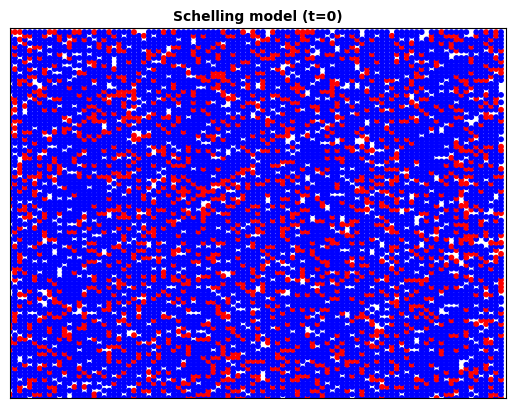

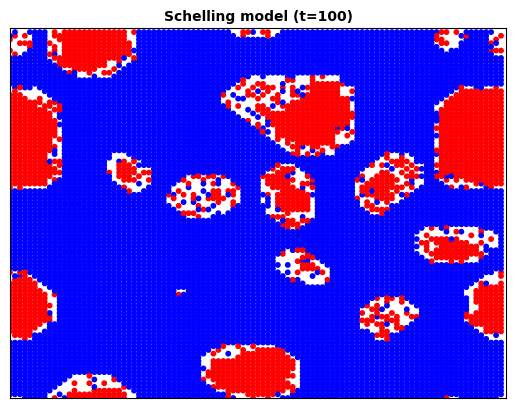

In [34]:
def extract_data(model):
    """
    Extracts the data from the model and returns it as a DataFrame.
    """

    # Extract data from model
    x_coords = np.array([agent.pos[0] for agent in model.schedule.agents])  # Agent x coords
    y_coords = np.array([agent.pos[1] for agent in model.schedule.agents])  # Agent y coords
    wealths = np.array([agent.wealth for agent in model.schedule.agents])   # Agent wealths 
    types = np.array([agent.type for agent in model.schedule.agents])       # Agent types
    return x_coords, y_coords, wealths, types


def plot2D_modelWealth(model):
    """
    Plots a 2D density heatmap of the model.
        x-axis: x position
        y-axis: y position
        weights: wealth
    """

    # Extract data from model
    x_coords, y_coords, wealths, types = extract_data(model)
    df = pd.DataFrame({'x_pos': x_coords, 'y_pos': y_coords, 'wealth': wealths, 'type': types})

    # Create the 2D density heatmap
    fig = px.density_heatmap(df, x='x_pos', y='y_pos', z='wealth', nbinsx=model.width, nbinsy=model.height)

    # Set axis labels
    fig.update_layout(
        height=720, width=720,
        xaxis_title='X', yaxis_title='Y', 
        coloraxis_colorbar_title='Wealth',
        title=f'Wealth distribution (t={model.schedule.steps})'
    )

    # Show the plot
    fig.show()

def plot2D_modelTypes(model):
    fig, ax = plt.subplots()

    # If you want to run the simulation with more than 7 colors, you should set agent_colors accordingly
    agent_colors = {0: 'b', 1: 'r', 2: 'g', 3: 'c', 4: 'm', 5: 'y', 6: 'k'}

    positions = [agent.pos for agent in model.schedule.agents]
    types = [agent.type for agent in model.schedule.agents]
    colors = [agent_colors[agent_type] for agent_type in types]

    ax.scatter(*zip(*positions), color=colors, s=10)

    ax.set_title(f'Schelling model (t={model.schedule.steps})', fontsize=10, fontweight='bold')
    ax.set_xlim([0, model.width])
    ax.set_ylim([0, model.height])
    ax.set_xticks([])
    ax.set_yticks([])

    plt.show()

# Define model parameters
heigth, width = 100, 100
density = 0.9
fixed_areas_pc = 0.0
popilation_sizes = [0.8, 0.2]
homophily = 5
cluster_threshold = 4

# Create the model
model = Schelling(heigth, width, density, fixed_areas_pc, popilation_sizes, homophily, cluster_threshold)

plot2D_modelTypes(model)
plot2D_modelWealth(model)
for i in range(100):
    model.step()
plot2D_modelTypes(model)
plot2D_modelWealth(model)

In [12]:
def plot2D_v2_model(model):
    """
    Plots a 2D density heatmap of the model.

    Note: V2 adds markers for each agent. However, 
          it doesn't work well for large scales.
    """
    x_coords, y_coords, wealths, types = extract_data(model)

    fig = go.Figure()

    type_markers = ['x', 'circle', 'square', 'diamond', 'triangle-up', 'triangle-down']  # Define marker shapes
    type_colors = ['red', 'blue', 'green', 'orange', 'purple', 'pink']  # Define marker colors

    for t in set(types):
        mask = types == t
        x = x_coords[mask]
        y = y_coords[mask]

        fig.add_trace(go.Scatter(
            x=x,
            y=y,
            mode='markers',
            showlegend=False,
            marker=dict(
                symbol=type_markers[t],
                opacity=0.7,
                color=type_colors[t],
                size=8,
                line=dict(width=1),
            )
        ))

    fig.add_trace(go.Histogram2d(
        x=x_coords,
        y=y_coords,
        colorscale='YlGnBu',
        zmax=max(wealths),
        nbinsx=14,
        nbinsy=14,
        zauto=False,
        # Add weights
        z=wealths,
        histfunc='sum',
        opacity=0.7,
    ))

    fig.update_layout(
        xaxis_title='X', yaxis_title='Y', coloraxis_colorbar_title='Wealth',
        xaxis=dict(ticks='', showgrid=False, zeroline=False, nticks=20),
        yaxis=dict(ticks='', showgrid=False, zeroline=False, nticks=20),
        autosize=False,
        height=720,
        width=720,
        hovermode='closest',
    )

    fig.show()

# Define model parameters
heigth, width = 10, 10
density = 0.97
fixed_areas_pc = 0.0
popilation_sizes = [0.5, 0.5]
homophily = 3
cluster_threshold = 4

# Create the model
model = Schelling(heigth, width, density, fixed_areas_pc, popilation_sizes, homophily, cluster_threshold)

plot2D_v2_model(model)
for i in range(10):
    model.step()
plot2D_v2_model(model)

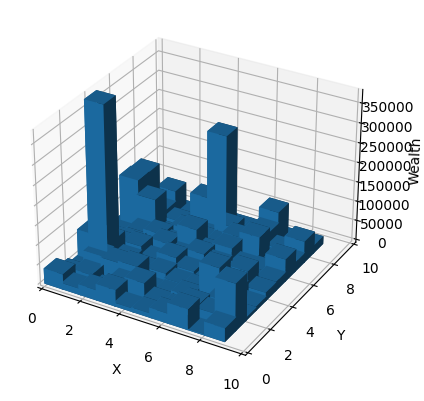

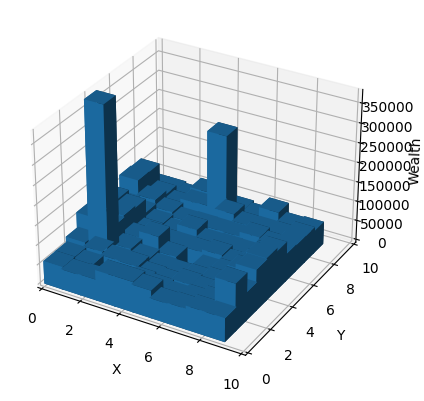

In [13]:
def plot3D_model(model):
    """
    Plots a 3D bar chart of the model.
        x-axis: x position
        y-axis: y position
        z-axis: wealth
        color: agent type

    Note: Nice to track the distribution of wealth over time.
             Agent types are mapped to colors.
    """

    # Extract data
    x_coords, y_coords, wealths, types = extract_data(model)

    # Create the 3D bar chart
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Create the histogram
    hist, x_edges, y_edges = np.histogram2d(x_coords, y_coords, bins=(model.width, model.height), weights=wealths)

    # Get the coordinates of the edges for the plotting
    x_pos, y_pos = np.meshgrid(x_edges[:-1], y_edges[:-1], indexing='ij')
    x_pos = x_pos.ravel()
    y_pos = y_pos.ravel()
    z_pos = np.zeros_like(x_pos)

    # Get the heights for the bars and normalize
    dx = dy = 1  # Width and depth of the bars
    dz = hist.ravel()

    # Create the 3D bars
    ax.bar3d(x_pos, y_pos, z_pos, dx, dy, dz)

    # Set the plot limits
    ax.set_xlim(0, model.width)
    ax.set_ylim(0, model.height)
    ax.set_zlim(0, dz.max())  # Normalize the wealth values to [0, 1] for the z-axis

    # Set axis labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Wealth')

    plt.show()

# Define model parameters
heigth, width = 10, 10
density = 0.97
fixed_areas_pc = 0.0
popilation_sizes = [0.8, 0.2]
homophily = 3
cluster_threshold = 4

# Create the model
model = Schelling(heigth, width, density, fixed_areas_pc, popilation_sizes, homophily, cluster_threshold)

plot3D_model(model)
for i in range(5):
    model.step()
plot3D_model(model)

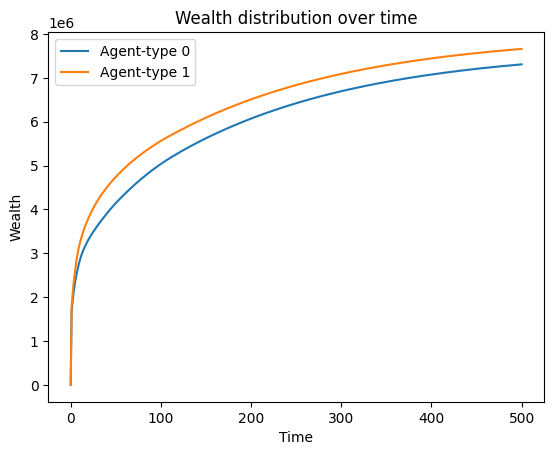

In [14]:
def wealth_dist_lineplot(model):
    """
    Creates a line plot of the wealth distribution over time.
    """

    # Extract data
    wealth_dist = model.datacollector.get_model_vars_dataframe()['wealth_dist']
    time = np.arange(len(wealth_dist))

    for type in range(model.N):
        plt.plot(time, wealth_dist.apply(lambda x: x[type]), label=f'Agent-type {type}')    

    # Adding labels and title
    plt.xlabel('Time')
    plt.ylabel('Wealth')
    plt.title('Wealth distribution over time')

    # Adding a legend
    plt.legend()

    # Displaying the chart
    plt.show()

# Define model parameters
heigth, width = 10, 10
density = 0.97
fixed_areas_pc = 0.0
popilation_sizes = [0.5, 0.5]
homophily = 3
cluster_threshold = 4

# Create the model
model = Schelling(heigth, width, density, fixed_areas_pc, popilation_sizes, homophily, cluster_threshold)

for i in range(500):
    model.step()
wealth_dist_lineplot(model)